In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl



from pyrLK3 import PyrLK3
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle
import bobsegutils as bsu

from skimage.draw import circle

import csv

from skimage import io

import math

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
filename = '/Users/prakash/Desktop/LK3.tif'
myosin_channel = imread(filename)
print('Shape of stack:', myosin_channel.shape)
sigma = [0.,0.,2,2]
#myosin_channel_smooth = gaussian(myosin_channel,sigma)

Shape of stack: (2, 6, 896, 1086)


In [3]:
print(myosin_channel[1].shape[1])

896


In [4]:
Flow = PyrLK3(myosin_channel[0], myosin_channel[1], myosin_channel[1])

In [5]:
flows = Flow.calc_flow()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [3]:
flows = bsu.compute_flow( myosin_channel )
flow_x, flow_y = bsu.split_flow_components( flows )
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

............................................................. ...done!


### The manually tracked coordinates from Fiji are processed before plotting

In [5]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
for i in range(1,8,1):
    #with open("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantification/time"+str(i)+"-"+str(i+1)+"/time_00"+str(i+1)+".csv","r") as source:
    with open("/Users/prakash/Desktop/BobSegDataAndResults/GoodData/2018-06-05_fromMark/20180604_LP823_Control-03_Coupled/FlowQuantification/time"+str(i)+"-"+str(i+1)+"/time_00"+str(i+1)+".csv","r") as source:
        rdr= csv.reader( source )
        with open("/Users/prakash/Desktop/BobSegDataAndResults/GoodData/2018-06-05_fromMark/20180604_LP823_Control-03_Coupled/FlowQuantification/time"+str(i)+"-"+str(i+1)+"/"+"Resultstime"+str(i)+"-"+str(i+1)+".csv","w") as result:
        #with open("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantification/time"+str(i)+"-"+str(i+1)+"/"+"Resultstime"+str(i)+"-"+str(i+1)+".csv","w") as result:
            wtr= csv.writer( result )
            for r in rdr:
                wtr.writerow( (r[1], r[2]) )

In [6]:
def load_file(filename):
    '''Make a list of tuples from a csv file
    '''
    fp = open(filename, 'Ur')
    data_list = []
    for line in fp:
        data_list.append(tuple((line.strip().split(','))))
    fp.close()
    return data_list

In [7]:
# The above created list elememts are string, we convert them to float below
center_points = []
manual_track_points = []
for f in range(1,8,1):
    #data_list = load_file("/Users/prakash/Desktop/BobSegDataAndResults/FlowQuantification/time"+str(f)+"-"+str(f+1)+"/Resultstime"+str(f)+"-"+str(f+1)+".csv")
    data_list = load_file("/Users/prakash/Desktop/BobSegDataAndResults/GoodData/2018-06-05_fromMark/20180604_LP823_Control-03_Coupled/FlowQuantification/time"+str(f)+"-"+str(f+1)+"/Resultstime"+str(f)+"-"+str(f+1)+".csv")
    datal = data_list[1:] # Ignoring the header row (first row of csv file)
    half = int(len(datal)/2)
    first_half = datal[0:half]
    second_half = datal[half:]
    new_first_half_list = []
    new_second_half_list = []
    for element in range(len(first_half)):
        number_element_first_half = []
        number_element_second_half = []
        number_element_first_half.append((float(first_half[element][0])))
        number_element_first_half.append((float(first_half[element][1])))
        new_first_half_list.append(tuple(number_element_first_half))
        number_element_second_half.append((float(second_half[element][0])))
        number_element_second_half.append((float(second_half[element][1])))
        new_second_half_list.append(tuple(number_element_second_half))
    center_points.append(new_first_half_list)
    manual_track_points.append(new_second_half_list)

/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 'U' mode is deprecated


In [8]:
flow_points = []
for frame, points in enumerate(center_points):
    flow_points_per_frame = []
    for i in range(len(points)):
        position = bsu.update_pos(points[i], frame, avg_flow_x, avg_flow_y )
        flow_points_per_frame.append(position)
    flow_points.append(flow_points_per_frame)

In [9]:
for i in range(len(center_points)):
    print('In frame',i, 'the number of points is:',len(center_points[i]))

In frame 0 the number of points is: 2
In frame 1 the number of points is: 4
In frame 2 the number of points is: 5
In frame 3 the number of points is: 2
In frame 4 the number of points is: 1
In frame 5 the number of points is: 2
In frame 6 the number of points is: 3


In [10]:
center_points_flat_list = [item for sublist in center_points for item in sublist]
manual_track_points_flat_list = [item for sublist in manual_track_points for item in sublist]
flow_points_flat_list = [item for sublist in flow_points for item in sublist]

In [11]:
def subVector(vec1, vec2):
    """Makes a vector given two points using B-A given the coordinates of two points A and B
    """
    return [(vec2[0] - vec1[0], vec2[1] - vec1[1]) for vec1, vec2 in zip(vec1, vec2)] 

In [12]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  
    """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [13]:
center_to_manual_vectors = subVector(center_points_flat_list, manual_track_points_flat_list)
center_to_flow_vectors = subVector(center_points_flat_list, flow_points_flat_list)
delta = []
for i in range(len(center_to_manual_vectors)):
    angle_rad = angle_between( center_to_flow_vectors[i], center_to_manual_vectors[i])
    angle_deg = math.degrees(angle_rad)
    delta.append(angle_deg)

In [14]:
delta_l = []
for i in range(len(center_points_flat_list)):
    r2 = bsu.euclid_dist(center_points_flat_list[i], flow_points_flat_list[i])
    r1 = bsu.euclid_dist(center_points_flat_list[i], manual_track_points_flat_list[i])
    position_offset = r2-r1
    delta_l.append(position_offset)

In [27]:
print(delta_l)

[-6.0520839152699555, -3.671777139023831, -1.8562597609302727, -6.1534214299447685, -1.5757769114113427, -1.420997620488567, -2.0118434185312335, -0.6571567473072033, -4.648924546688974, -5.5653429195067545, -6.692188403630017, 1.0710548321531603, -1.1908642287445836, -3.3393769103819233, -0.8330062256916091, -2.4736595978528695, -1.9873577144034593, 1.408973560197743, -1.8702368088911108]


In [16]:
print(len(center_points_flat_list))

19


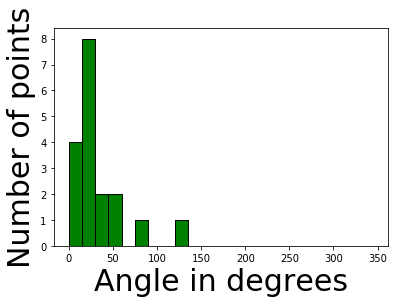

<Figure size 3600x3600 with 0 Axes>

In [22]:
plt.hist(delta[1:], bins=range(0,360,15),histtype='bar', color='green', ec='black')
plt.xlabel('Angle in degrees',fontsize=30)
plt.ylabel('Number of points',fontsize=30)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.figure(figsize=(50,50))
plt.show()

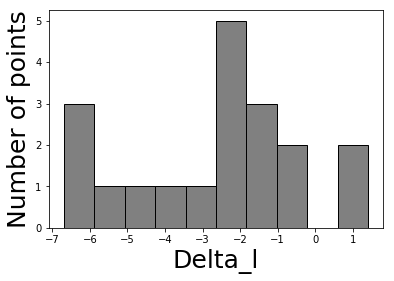

In [26]:
plt.hist(delta_l,histtype='bar', color='gray', ec='black')
plt.xlabel('Delta_l',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

### Computing and plotting results

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


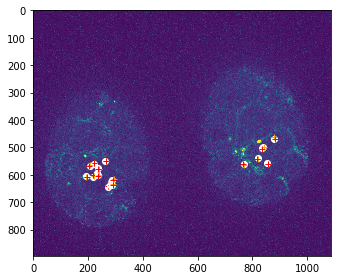

In [24]:
fig = plt.figure()
for element in range(len(center_points_flat_list)):
    print(element)
    plt.plot(center_points_flat_list[element][0],center_points_flat_list[element][1],'o',color='white') #Starting position
    plt.plot(manual_track_points_flat_list[element][0],manual_track_points_flat_list[element][1],'+',color='orange') #Updated position by flow computation
    plt.plot(flow_points_flat_list[element][0],flow_points_flat_list[element][1],'+',color='red') #Updated position by flow computation
    plt.imshow(myosin_channel[-1])
    
    fig.tight_layout()    

In [19]:
print(len(center_points_flat_list))

56
